In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import allison
from allison import tensor
from allison.nn import NeuralNetwork,Linear, CrossEntropyLoss,Relu,BatchNorm1D
from allison.optim import SGDMomentum, RMSprop, Adam
from allison.datasets import train_test_split,DataLoader,Dataset
from allison.metrics import confusion_matrix,classification_report
from datetime import datetime

In [3]:
device = "gpu" if allison.cuda.is_available() else "cpu"
device

Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


'gpu'

In [4]:
data = pd.read_csv("../data/digit-recognizer/train.csv")

In [5]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_train,data_test = train_test_split(data,test_size=0.2)

In [7]:
X_train = data_train.drop("label",axis=1).values
Y_train = data_train["label"].values

X_test = data_test.drop("label",axis=1).values
Y_test = data_test["label"].values

train_dataset = Dataset(X_train,Y_train)    
test_dataset = Dataset(X_test,Y_test)

train_dataloader = DataLoader(train_dataset,batch_size=64)
test_dataloader = DataLoader(test_dataset,batch_size=64)

In [8]:
for x,y in train_dataloader:
    print(x.shape,y.shape)
    break

(64, 784) (64,)


In [9]:
class Model(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.linear1 = Linear(784,128,bias=False)
        self.bn1 = BatchNorm1D(128)
        self.linear2 = Linear(128,64)
        self.linear3 = Linear(64,10)
        self.relu = Relu()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x
    

model = Model()
model.to(device)
loss_fn = CrossEntropyLoss()

optimizer = RMSprop(model.parameters(), lr=1e-3)


In [10]:
start = datetime.now()

epochs = 100

for epoch in range(epochs+1):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in train_dataloader:
        x = tensor(x, device=device)
        y = tensor(y, device=device)

        # Forward
        y_pred = model(x)
        loss = loss_fn(y, y_pred)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular loss y accuracy
        total_train_loss += loss.data.get() * len(y)  # ponderar por tamaño del batch
        correct_train += (y_pred.data.argmax(axis=1) == y.data).sum().get()
        total_train += len(y)

    avg_train_loss = total_train_loss / total_train
    avg_train_acc = correct_train / total_train

    # --- Validación/Test ---
    if epoch % 5 == 0:
        with allison.no_grad():
            model.eval()
            total_test_loss = 0.0
            correct_test = 0
            total_test = 0

            for x, y in test_dataloader:
                x = tensor(x, device=device)
                y = tensor(y, device=device)

                y_pred = model(x)
                loss = loss_fn(y, y_pred)

                total_test_loss += loss.data.get() * len(y)
                correct_test += (y_pred.data.argmax(axis=1) == y.data).sum().get()
                total_test += len(y)

            avg_test_loss = total_test_loss / total_test
            avg_test_acc = correct_test / total_test
            
            print(f"[{device}] [{epoch:3d}/{epochs:3d}] | Loss: {avg_test_loss:.4f} | Acc Train: {100*avg_train_acc:.2f}% | Acc Test: {100*avg_test_acc:.2f}%")

        if avg_test_acc > 0.95:
            break
end = datetime.now()

delta = end-start
tiempo = delta.total_seconds()
print(f"Tiempo:{tiempo} segundos = {tiempo/60:.2f} min ")

[gpu] [  0/100] | Loss: 0.2872 | Acc Train: 87.63% | Acc Test: 92.14%
[gpu] [  5/100] | Loss: 0.1320 | Acc Train: 97.67% | Acc Test: 96.07%
Tiempo:8.760315 segundos = 0.15 min 


SDGMomentum

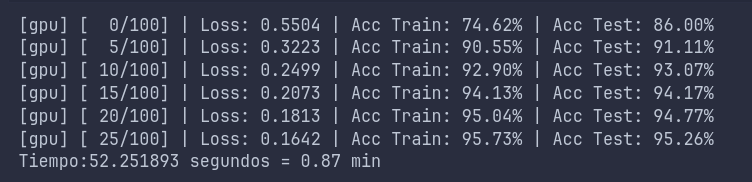

RMSprop

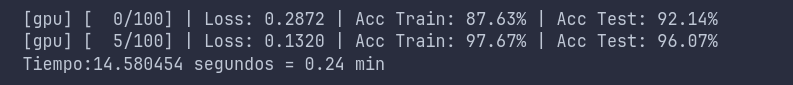

Adam

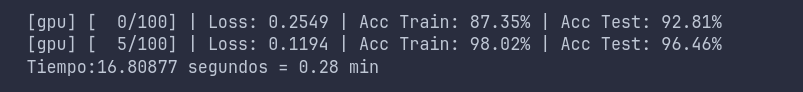

In [11]:
all_preds = np.array([])
all_targets = np.array([])

with allison.no_grad():
    model.eval()
    for x, y in test_dataloader:
        x = tensor(x, device=device)
        y = tensor(y, device=device)

        # Predicciones
        y_pred = model(x)
        preds = y_pred.data.argmax(axis=1).get()

        # Guardar predicciones y targets
        all_preds = np.append(all_preds,preds)
        all_targets = np.append(all_targets,y.data.get())


In [12]:
print(classification_report(all_targets,all_preds))

            precision   recall f1-score  support
0.0              0.98     0.98     0.98      798
1.0              0.96     0.99     0.97      920
2.0              0.98     0.97     0.97      797
3.0              0.95     0.97     0.96      858
4.0              0.93     0.98     0.95      813
5.0              0.95     0.98     0.96      772
6.0              0.97     0.98     0.98      849
7.0              0.94     0.98     0.96      929
8.0              0.97     0.91     0.94      810
9.0              0.98     0.87     0.92      854

accuracy                           0.96     8400
macro avg        0.96     0.96     0.96     8400
weighted avg     0.96     0.96     0.96     8400


<Axes: >

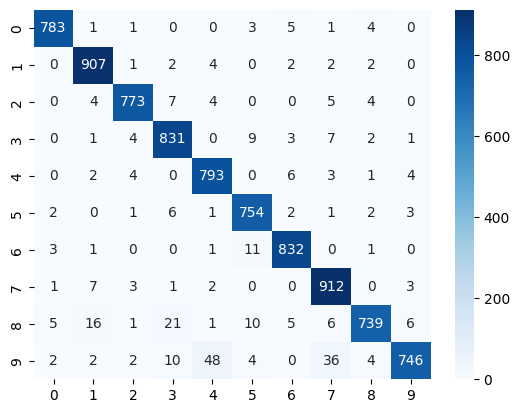

In [13]:
sns.heatmap(confusion_matrix(all_targets,all_preds), annot=True, cmap="Blues", fmt=".0f")